In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, recall_score, accuracy_score, mean_squared_error, confusion_matrix, make_scorer

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline

pd.options.mode.chained_assignment = None

# 1 - Load dataset
For now I'll work with 3 second samples. Later might try with 5sec samples

In [7]:
#features_3_sec = pd.read_csv('./Data/features_3_sec.csv')
dataset = pd.read_csv('./Data/final_dataset.csv')
dataset = dataset.drop(columns=['id', 'seen_by_model', 'createdAt', 'updatedAt', 'deletedAt'])
#features_30_sec = pd.read_csv('./Data/features_30_sec.csv')
dataset.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.441011,0.098403,0.308838,0.010569,3328.124539,8.107549e+05,3382.691560,114583.284474,7897.323031,1.917331e+06,...,42.023411,-5.012711,66.960938,-0.968601,87.470032,2.991356,59.765133,-1.670792,59.670425,7
1,0.370265,0.083063,0.171207,0.006743,2915.715009,1.556398e+06,2599.689672,324970.562618,5661.195497,5.154728e+06,...,94.394127,1.313031,144.447861,5.818873,138.011856,4.596396,144.546539,1.729125,211.818741,7
2,0.385647,0.071537,0.229402,0.015564,3880.270183,2.722230e+06,3186.927682,254165.389259,7703.815192,5.101757e+06,...,89.115379,5.156198,82.118690,2.303481,64.394051,0.785539,59.500866,-2.959064,73.443031,7
3,0.407606,0.107868,0.079086,0.000538,2271.813617,6.391978e+05,2707.634095,187545.070021,5239.177972,3.272871e+06,...,58.049915,-11.866402,100.287689,-3.473018,122.847267,-2.771165,68.308220,-0.633971,63.867836,7
4,0.397764,0.072330,0.242004,0.005612,2911.060481,5.488350e+05,2956.118960,145420.851816,6284.660711,2.669257e+06,...,50.164764,3.505230,64.743500,3.052081,117.361862,-1.915870,47.333481,2.078118,60.737377,7


In [229]:
dataset.describe()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
count,18174.000000,18174.000000,18174.000000,18174.000000,18174.000000,1.817400e+04,18174.000000,1.817400e+04,18174.000000,1.817400e+04,...,18174.000000,18174.000000,18174.000000,18174.000000,18174.000000,18174.000000,18174.000000,18174.000000,18174.000000,18174.000000
mean,0.379295,0.077021,0.135572,0.002687,2134.875117,4.510874e+05,2223.325359,1.417981e+05,4438.402746,1.835587e+06,...,54.598758,-3.468213,55.100700,1.714759,56.033552,-2.496534,59.438897,0.900708,63.174340,4.106086
std,0.142422,0.036724,0.084039,0.003816,802.236797,4.533324e+05,622.509385,1.312559e+05,1785.475510,1.606003e+06,...,34.072636,4.792359,34.595491,4.831382,35.939634,4.548077,38.850464,4.991360,44.661200,2.719498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,...,0.000000,-29.104006,0.000000,-29.340727,0.000000,-30.064680,0.000000,-30.964809,0.000000,0.000000
25%,0.285098,0.053865,0.081105,0.000547,1527.237053,1.286404e+05,1856.116472,4.986841e+04,3064.469951,5.677438e+05,...,33.935047,-6.441645,33.550750,-1.074171,34.136117,-5.176787,35.446934,-2.055657,35.867638,2.000000
50%,0.378518,0.077365,0.119931,0.001442,2197.585269,3.133750e+05,2337.079347,1.107969e+05,4668.758157,1.475304e+06,...,48.061140,-3.548226,48.219650,1.847504,48.411140,-2.640953,51.189043,1.098168,53.174356,4.000000
75%,0.471700,0.100983,0.170582,0.003007,2701.097807,6.432060e+05,2668.133136,1.970407e+05,5721.218440,2.747373e+06,...,67.605717,-0.607902,68.607605,4.625885,68.796925,0.011364,73.783278,4.028334,78.724277,6.000000
max,1.000000,0.218875,0.511213,0.046327,5723.361241,8.328621e+06,3900.406003,1.928908e+06,9862.207031,1.708614e+07,...,558.112000,30.542461,576.210999,31.429256,628.466858,28.347557,765.618164,32.883530,997.057739,9.000000


In [230]:
dataset.columns

Index(['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'tempo', 'mfcc1_mean', 'mfcc1_var',
       'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean',
       'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var',
       'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean',
       'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var',
       'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean',
       'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var',
       'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean',
       'mfcc19_var', 'mfcc20_mean', 'mfcc20_var', 'label'],
      dtype='object')

# 2 - Analyse dataset


In [8]:
dataset = dataset.sample(frac=1)
training_set, testing_set, _, __ = train_test_split(dataset, dataset, test_size=0.1)

In [9]:
len(training_set), len(testing_set)

(16356, 1818)

In [392]:
len(training_set.columns)

56

## 2.1 - Label feature correlations
The following heatmap shows the correlation between every feature and the prediction label. With this data, we can check how much each feature affects the outcome of the label and find out which ones can be dropped (values closer to 0), which by analysing the heatmap, we can observe that this is the case for some features.

<AxesSubplot:>

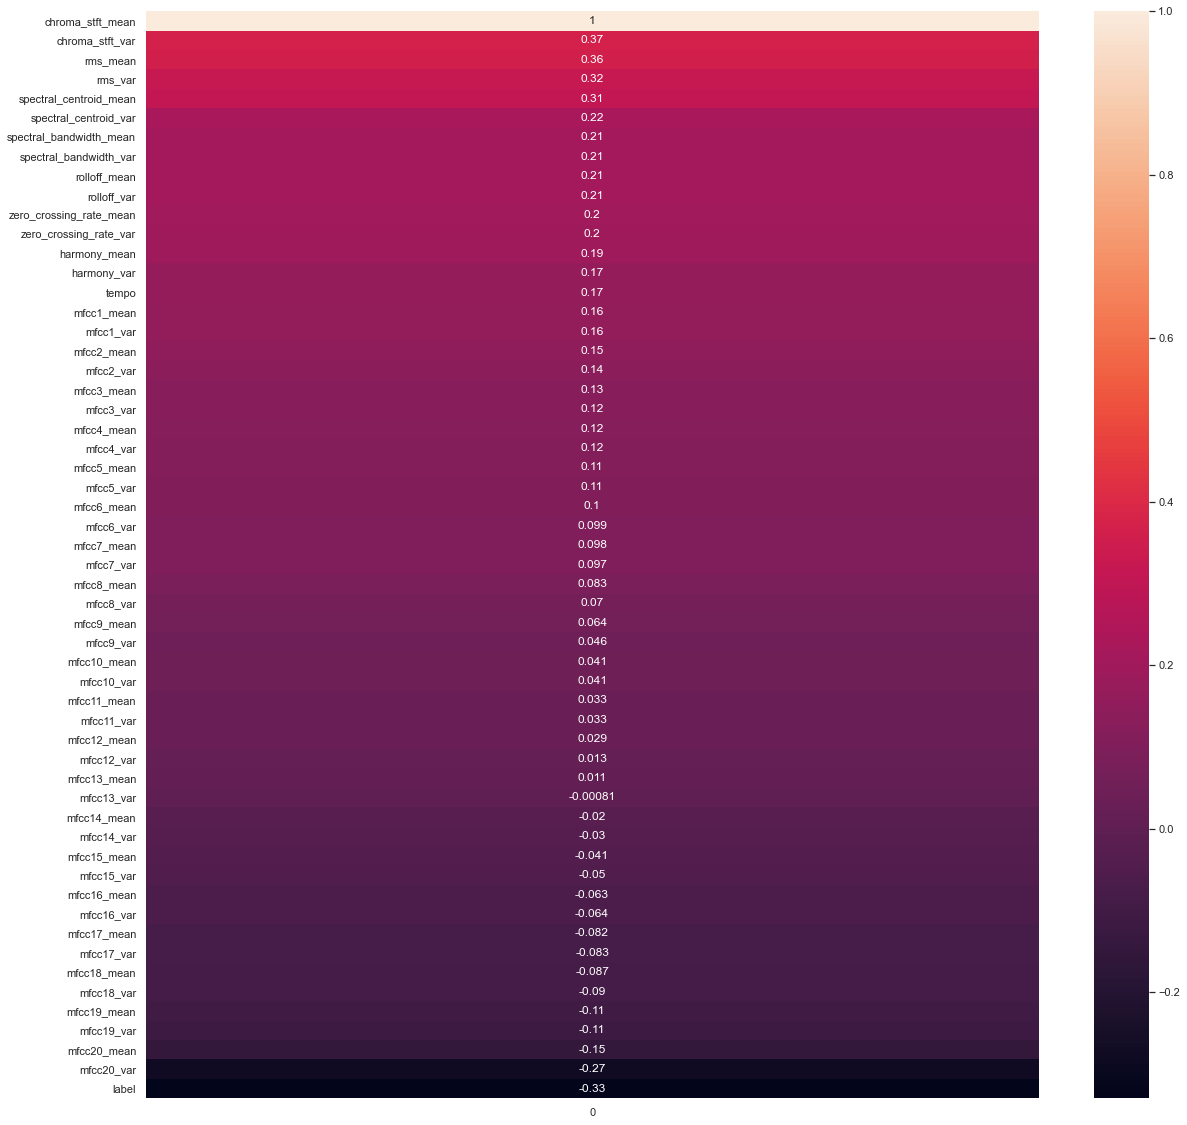

In [393]:
training_corr = training_set.corr()
corr = pd.DataFrame(data=training_corr.label)
corr = corr.sort_values(by=['label'], ascending=False)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr.label.values.reshape(56,1),  annot=True, ax=ax, yticklabels=training_set.columns)

## 2.2 - Feature boxplotting
With the boxplots we can find out whether the dataset has outliers or not. By analysing the plots below, we can see that the majority of the mean based features don't have as much outliers as the variance based ones.

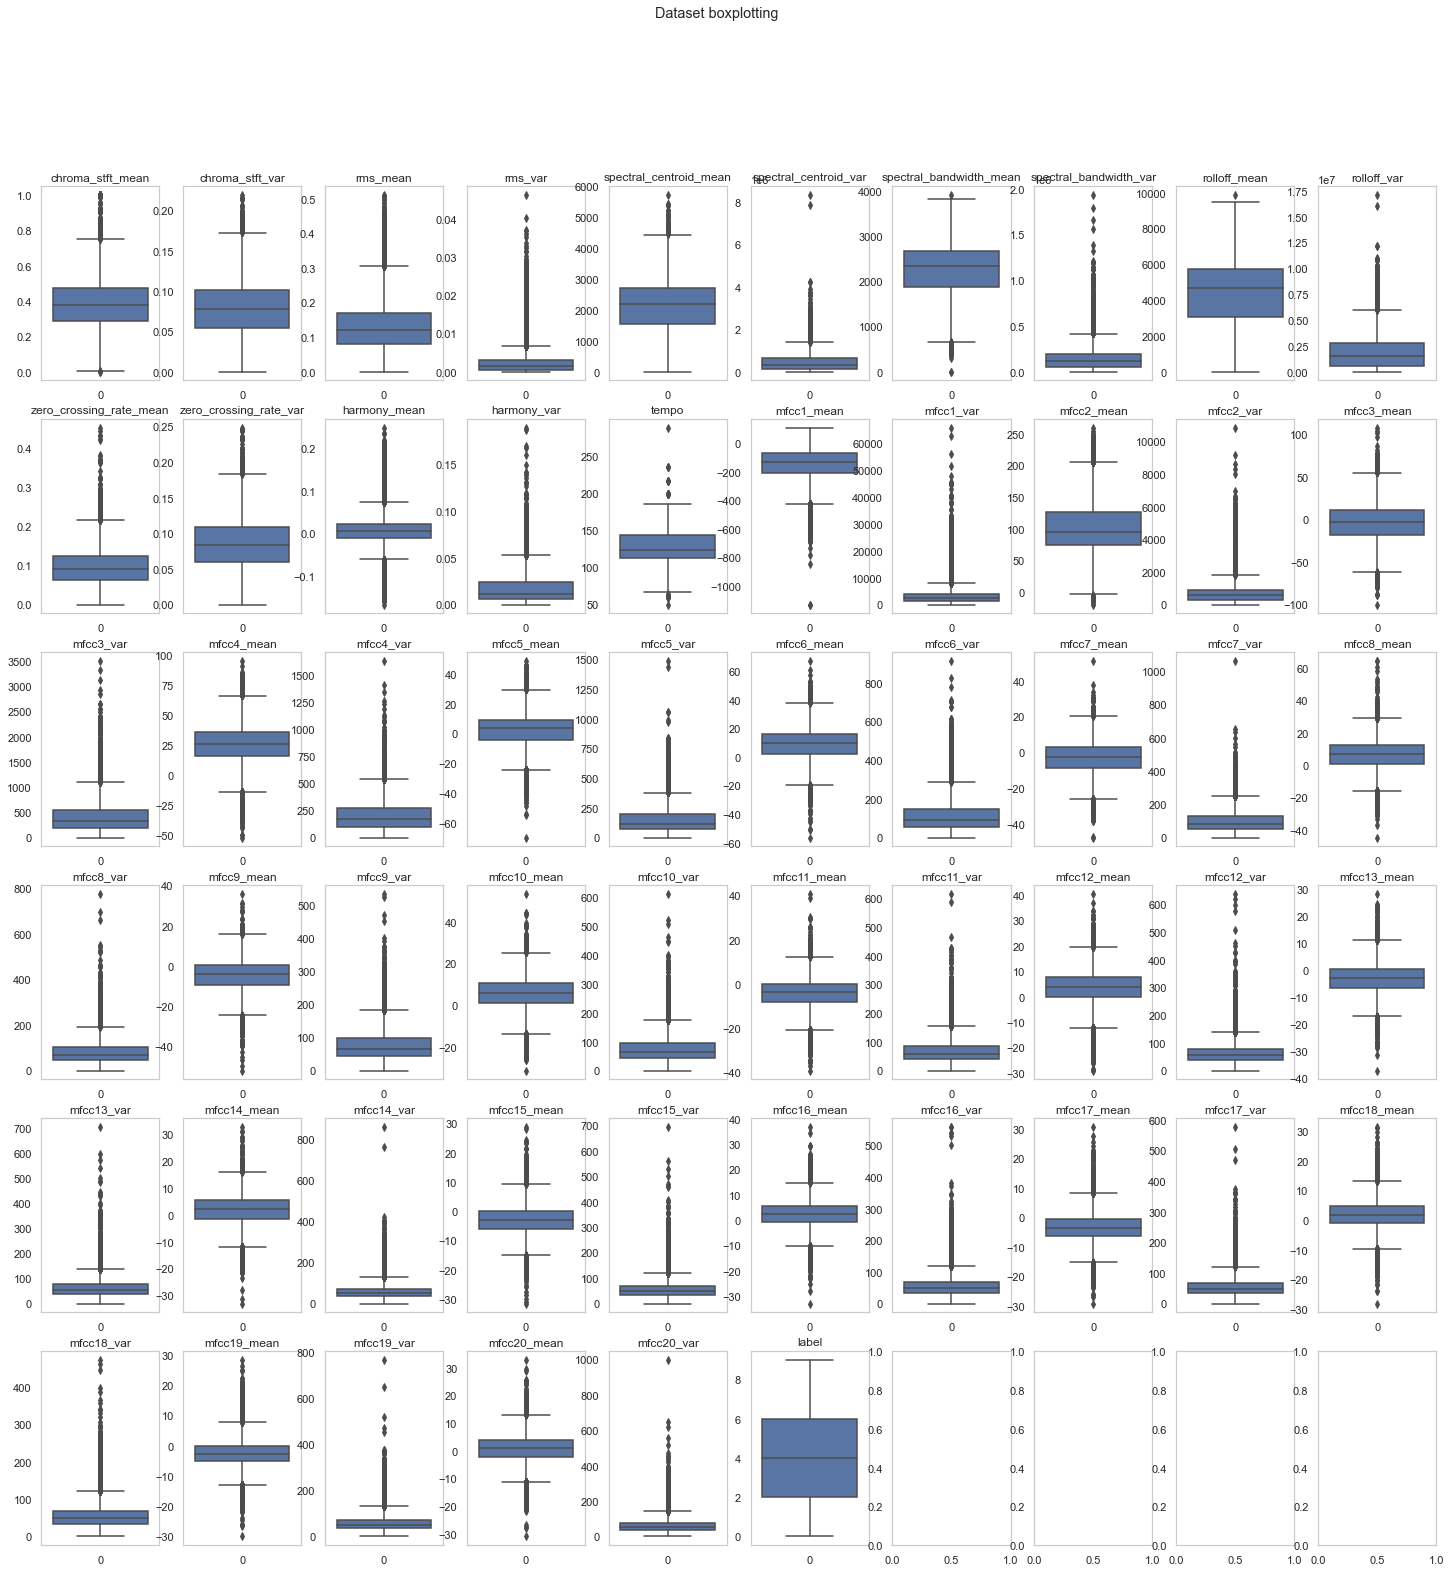

In [394]:
fig, axes = plt.subplots(6, 10, figsize=(25, 25))
fig.suptitle('Dataset boxplotting')

for r in range(6):
    for c in range(10):
        if r == 5 and c > 5: break
        col = training_set.columns[r*10+c]
        sns.boxplot(ax=axes[r, c], data=training_set[col])
        axes[r, c].set_title(col)

## 2.3 - Data distributions

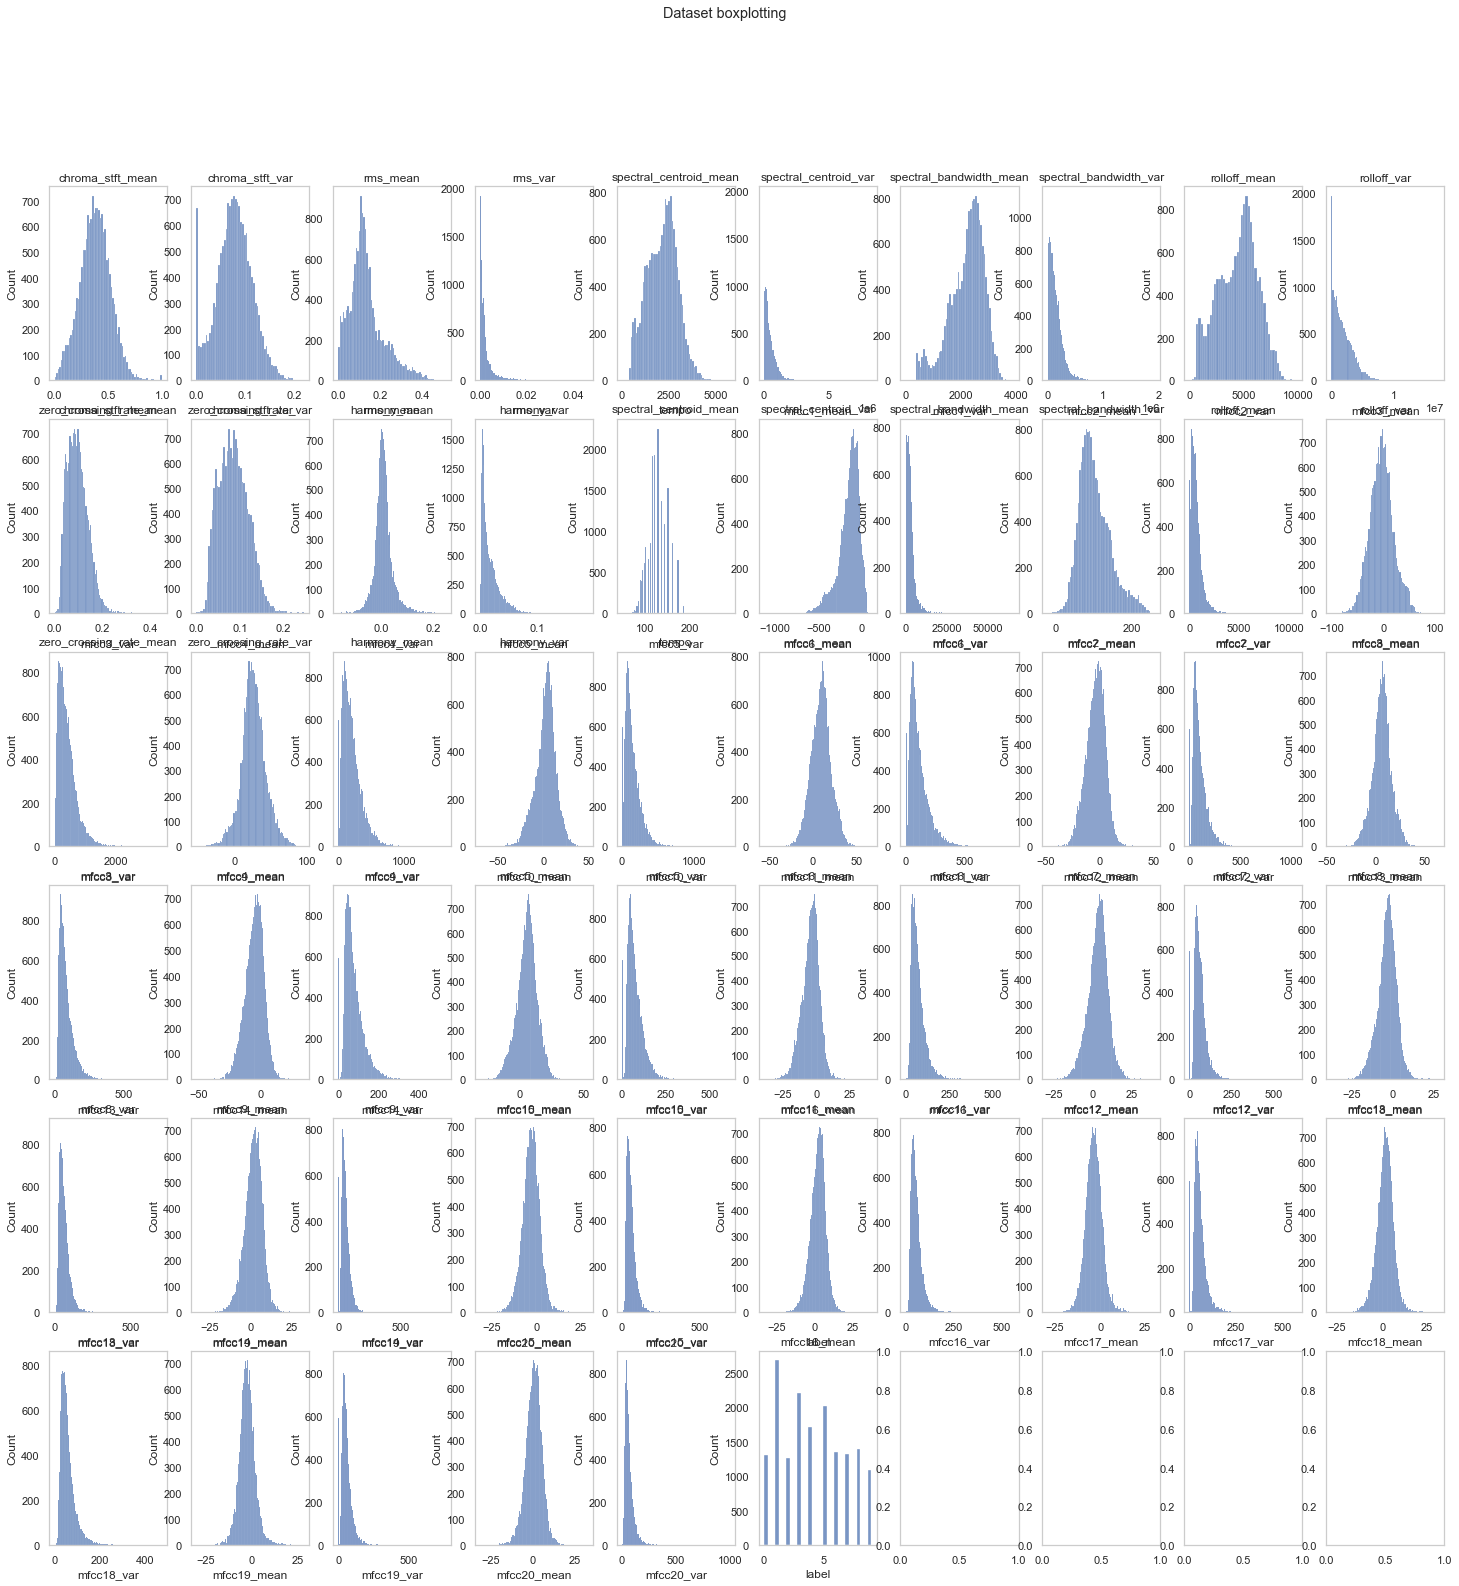

In [395]:
fig, axes = plt.subplots(6, 10, figsize=(25, 25))
fig.suptitle('Dataset boxplotting')

for r in range(6):
    for c in range(10):
        if r == 5 and c > 5: break
        col = training_set.columns[r*10+c]
        #sns.boxplot(ax=axes[r, c], data=training_set[col])
        sns.histplot(ax=axes[r, c], data=training_set[col])
        axes[r, c].set_title(col)

## 2.4 - Check and handle duplicates

In [10]:
duplicates = training_set[training_set.duplicated(training_set.columns[:len(training_set.columns)-1], keep=False) & ~training_set.duplicated(training_set.columns, keep=False)]
training_set = training_set.drop(duplicates.index)
len(training_set[training_set.duplicated(training_set.columns[:len(training_set.columns)-1], keep=False) & ~training_set.duplicated(training_set.columns, keep=False)])

0

## 2.5 - Data balance

As can be observed below, our dataset has some imbalances, which can hurt the performance of the models being trained. This can be fixed by sampling the data and rebalance the dataset.

In [11]:
unsampled_label_counts = {}
for i in range(10):
    unsampled_label_counts[str(i)] = len(training_set[training_set.label == i])
unsampled_label_counts

{'0': 1312,
 '1': 2681,
 '2': 1243,
 '3': 2186,
 '4': 1731,
 '5': 1990,
 '6': 1367,
 '7': 1350,
 '8': 1399,
 '9': 1087}

In [12]:
sampled_training_set = training_set.copy(deep=True)
min_label_count = np.min(list(unsampled_label_counts.values()))
print("Min value: ", min_label_count)

sampled_label_counts = {}
for i in range(10):
    if unsampled_label_counts[str(i)] > 1500:
        sample = sampled_training_set[sampled_training_set.label == i]
        sample = sample.sample(n=(len(sample) - 1500))
        sampled_training_set.drop(index=sample.index, inplace=True)
        print(len(sampled_training_set[sampled_training_set.label == i]))
    sampled_label_counts[str(i)] = len(sampled_training_set[sampled_training_set.label == i])
    
sampled_label_counts

Min value:  1087
1500
1500
1500
1500


{'0': 1312,
 '1': 1500,
 '2': 1243,
 '3': 1500,
 '4': 1500,
 '5': 1500,
 '6': 1367,
 '7': 1350,
 '8': 1399,
 '9': 1087}

In [13]:
training_set = sampled_training_set

# 3 - Data pre-processing

## 3.1 - Scale and normalize data

In [14]:
X_tmp = training_set.drop(columns='label')
y_tmp = pd.DataFrame(data=training_set.label.values, index=training_set.index, columns=['label'])

scaler = StandardScaler()
scaler.fit(X_tmp)
scaled_training_set = pd.DataFrame(scaler.transform(X_tmp), index=X_tmp.index, columns=X_tmp.columns)
scaled_training_set = pd.concat([scaled_training_set, y_tmp], axis=1, join='inner')
scaled_training_set.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
4063,-0.110116,-2.186272,2.485128,-0.716468,-1.277021,-1.060164,0.078667,-1.142681,-1.076586,-1.217454,...,-1.636765,1.083964,-1.617066,0.219087,-1.556465,2.031245,-1.532880,-0.166142,-1.469094,4
3367,-0.148269,-0.135560,0.401883,-0.041715,0.266900,-0.347263,-0.303851,-0.509304,-0.011432,-0.454453,...,-0.815567,-1.268875,-0.422179,-0.077665,-0.771244,0.228026,-0.639710,-0.526840,-0.775753,9
13175,-1.474195,-0.721265,-1.365016,-0.568965,-0.617925,-0.595687,-0.916433,-0.787858,-0.786228,-0.853722,...,-0.150691,0.091196,-0.276435,-0.416433,1.866914,-0.242040,0.902194,-1.391056,2.723534,1
461,-0.602451,0.189020,0.436289,0.875856,0.950942,2.355954,0.472736,0.862595,0.577161,1.544449,...,1.158860,0.902680,0.749941,0.827428,2.966731,1.819421,1.811700,0.077808,2.283784,7
12889,-0.973018,-1.133294,-1.345985,-0.644135,-1.039520,-0.964809,-1.162759,-0.894859,-1.183969,-1.087654,...,-0.706387,0.225275,-0.711984,-0.010067,-0.572587,-0.210684,-0.516793,-1.626137,-0.705461,1


In [15]:
X_tmp = testing_set.drop(columns='label')
y_tmp = pd.DataFrame(data=testing_set.label.values, index=testing_set.index, columns=['label'])

scaled_testing_set = pd.DataFrame(scaler.transform(X_tmp), index=X_tmp.index, columns=X_tmp.columns)
scaled_testing_set = pd.concat([scaled_testing_set, y_tmp], axis=1, join='inner')
scaled_testing_set.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
8258,1.225646,0.013556,-0.265094,-0.409382,1.503697,0.207694,0.907941,-0.347854,1.263716,-0.232811,...,-0.575678,0.330860,-0.409044,0.455189,-0.283730,-0.292896,-0.299260,1.077815,-0.339816,3
15255,0.028396,0.477351,-0.529650,0.414428,2.116004,2.267300,1.402592,-0.356249,1.792955,-0.204419,...,0.579623,0.239287,0.626216,-0.179800,0.615636,-0.182013,0.634032,-1.108747,0.490904,4
11709,-0.920577,0.101120,-1.101994,-0.556468,-1.966041,-1.051182,-3.228846,-1.108028,-2.192972,-1.214437,...,-0.760732,1.442217,-0.830135,0.202608,-0.385226,0.658337,-0.366196,-0.353302,1.052828,1
1635,-1.527982,-0.569322,-0.479599,-0.137423,-0.756811,-0.618460,-0.992319,-0.226100,-0.704790,-0.413384,...,-0.222051,0.654857,-0.057575,0.226989,1.900240,0.676218,0.145718,-0.383169,0.547762,0
4491,1.194455,0.120204,-0.324631,-0.037701,0.327352,-0.084396,0.338264,-0.735919,0.505529,-0.612023,...,-0.849755,-0.082121,-0.574308,0.946695,-0.882839,0.318339,-0.247580,0.204602,-0.779864,4


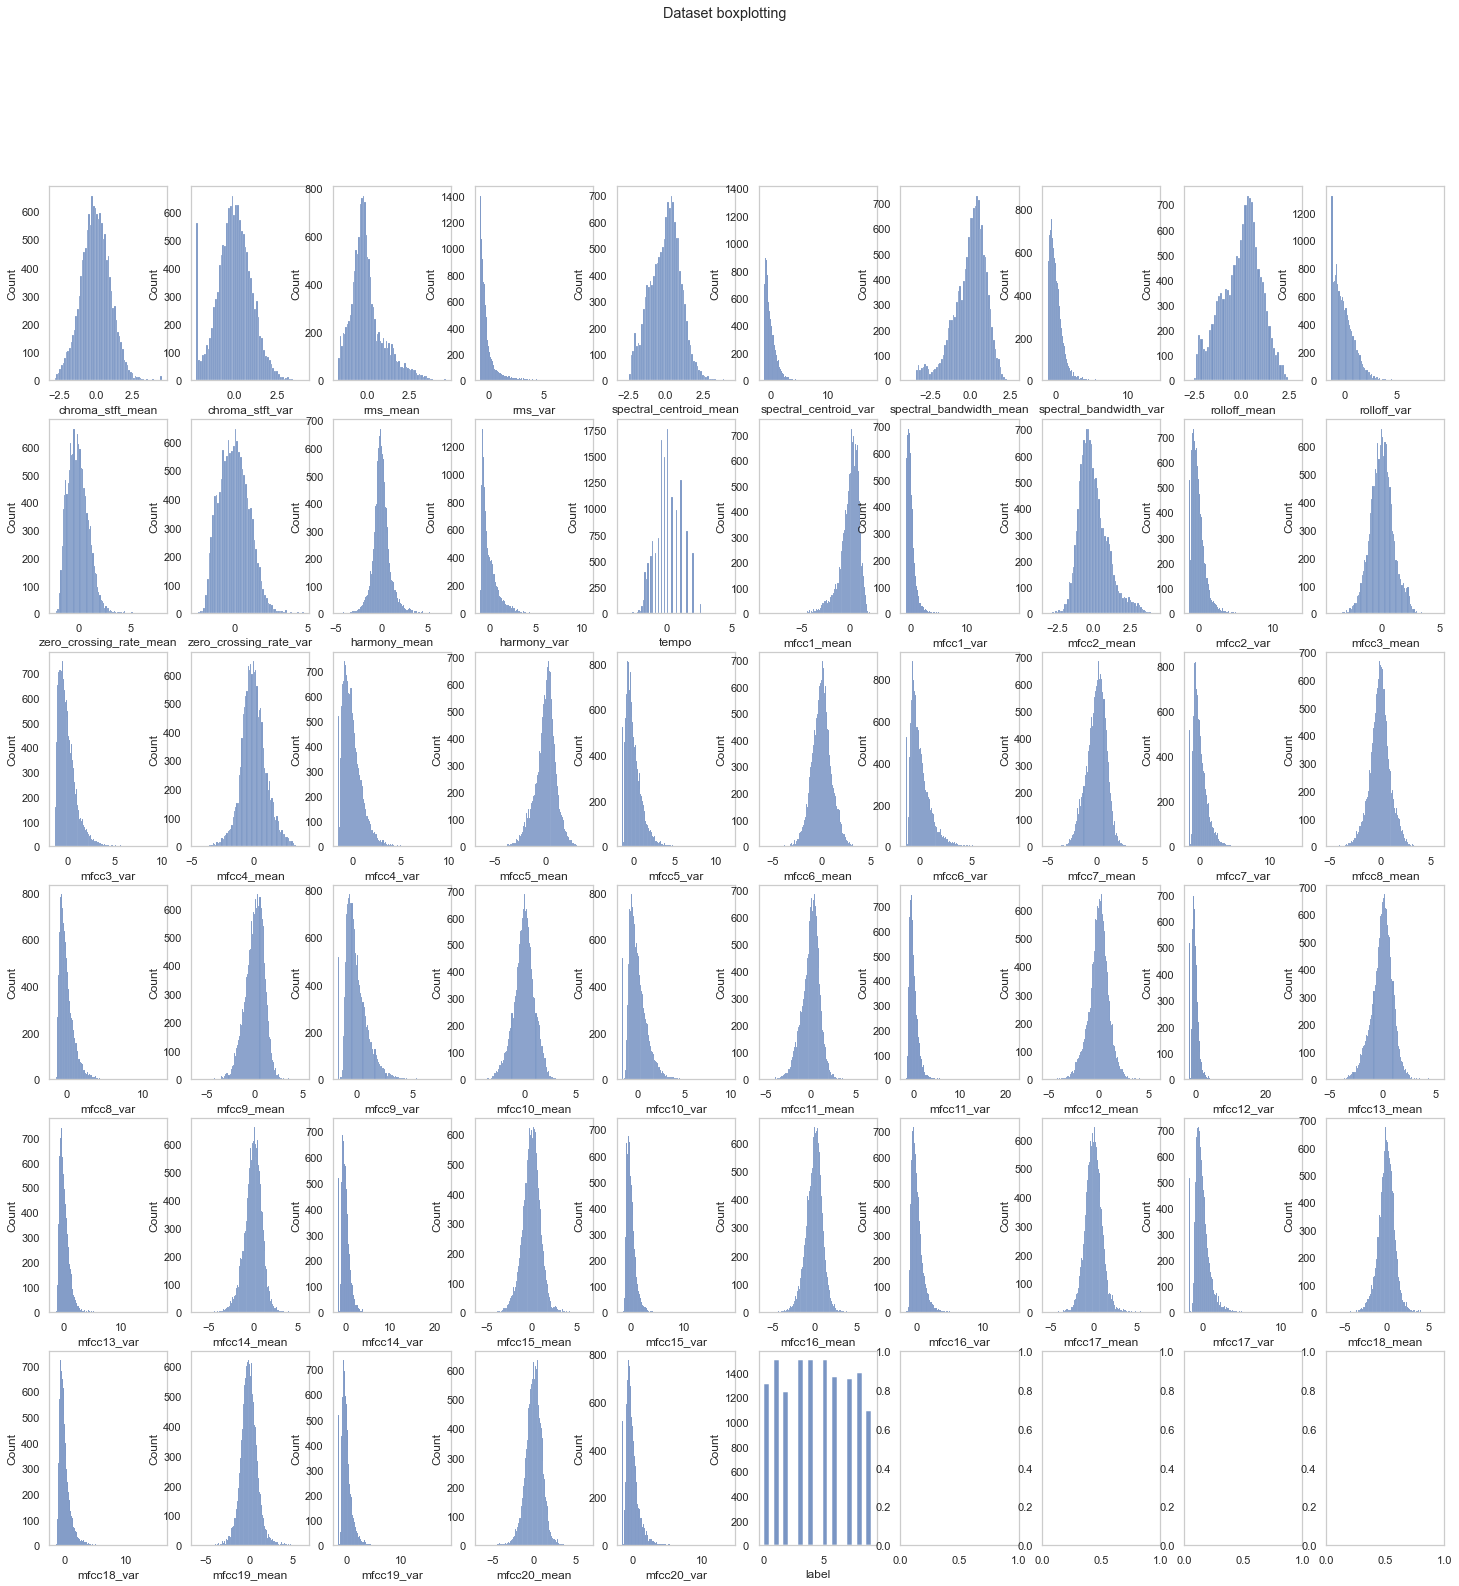

In [16]:
fig, axes = plt.subplots(6, 10, figsize=(25, 25))
fig.suptitle('Dataset boxplotting')

for r in range(6):
    for c in range(10):
        if r == 5 and c > 5: break
        col = scaled_training_set.columns[r*10+c]
        sns.histplot(ax=axes[r, c], data=scaled_training_set[col])

## 3.2 - Handle outliers

In [17]:
#outliers = {}
threshold = 3 # 3 standard deviations

for feature in training_set.drop(columns='label').columns:
    median = training_set[feature].median()
    std = training_set[feature].std()

    #outliers = training_set[(abs(training_set[feature] - median) / std) > threshold].index
    
    Q1 = training_set[feature].quantile(0.25)
    Q3 = training_set[feature].quantile(0.75)
    IQR = Q3 - Q1

    [MnIF, MxIF] = [Q1-1.5*IQR, Q3+1.5*IQR]
    [MnOF, MxOF] = [Q1-3*IQR, Q3+3*IQR]

    upper_outliers = training_set[training_set[feature] >= MxIF].index
    lower_outliers = training_set[training_set[feature] <= MnIF].index

    training_set.loc[training_set.index.isin(upper_outliers), feature] = training_set[feature].mean()
    training_set.loc[training_set.index.isin(lower_outliers), feature] = training_set[feature].mean()
    
    
    # Mean imputation
    #training_set.loc[training_set.index.isin(outliers), feature] = training_set[feature].mean()
    # Median imputation
    #training_set.loc[training_set.index.isin(outliers), feature] = training_set[feature].mean()
    # Mean imputation
    #training_set.loc[training_set.index.isin(outliers), feature] = training_set[feature].mean()


In [18]:
training_set.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
4063,0.368596,0.000000,0.138590,0.000000,1225.363895,0.000000,2328.246692,0.000000,2777.783203,0.000000e+00,...,0.000000,1.633321,0.000000,2.972852,0.000000,6.748488,0.000000,0.218384,0.000000,4
3367,0.363396,0.072220,0.170812,0.002577,2401.688128,321641.279442,2109.326386,81820.795810,4569.778030,1.217833e+06,...,27.466402,-9.680091,40.941032,1.559811,28.274485,-1.407585,34.364311,-1.545434,29.246450,9
13175,0.182663,0.051593,0.029148,0.000563,1727.533976,209559.030720,1758.737764,45836.643873,3266.277156,5.805562e+05,...,49.704350,-3.140313,45.934734,-0.053297,56.045671,-3.533727,93.688354,-5.771459,61.969182,1
461,0.301487,0.083651,0.173570,0.006081,2922.863698,478316.595394,2553.777480,259045.074321,5560.014385,4.408302e+06,...,93.504593,0.761633,81.101997,5.869582,56.045671,5.790395,128.681183,1.411301,61.969182,7
12889,0.250977,0.037083,0.030674,0.000276,1406.318074,43021.504201,1617.762035,32014.080360,2597.124125,2.071746e+05,...,31.118130,-2.495605,31.011312,1.881694,35.427780,-3.391899,39.093479,-6.921008,32.211514,1


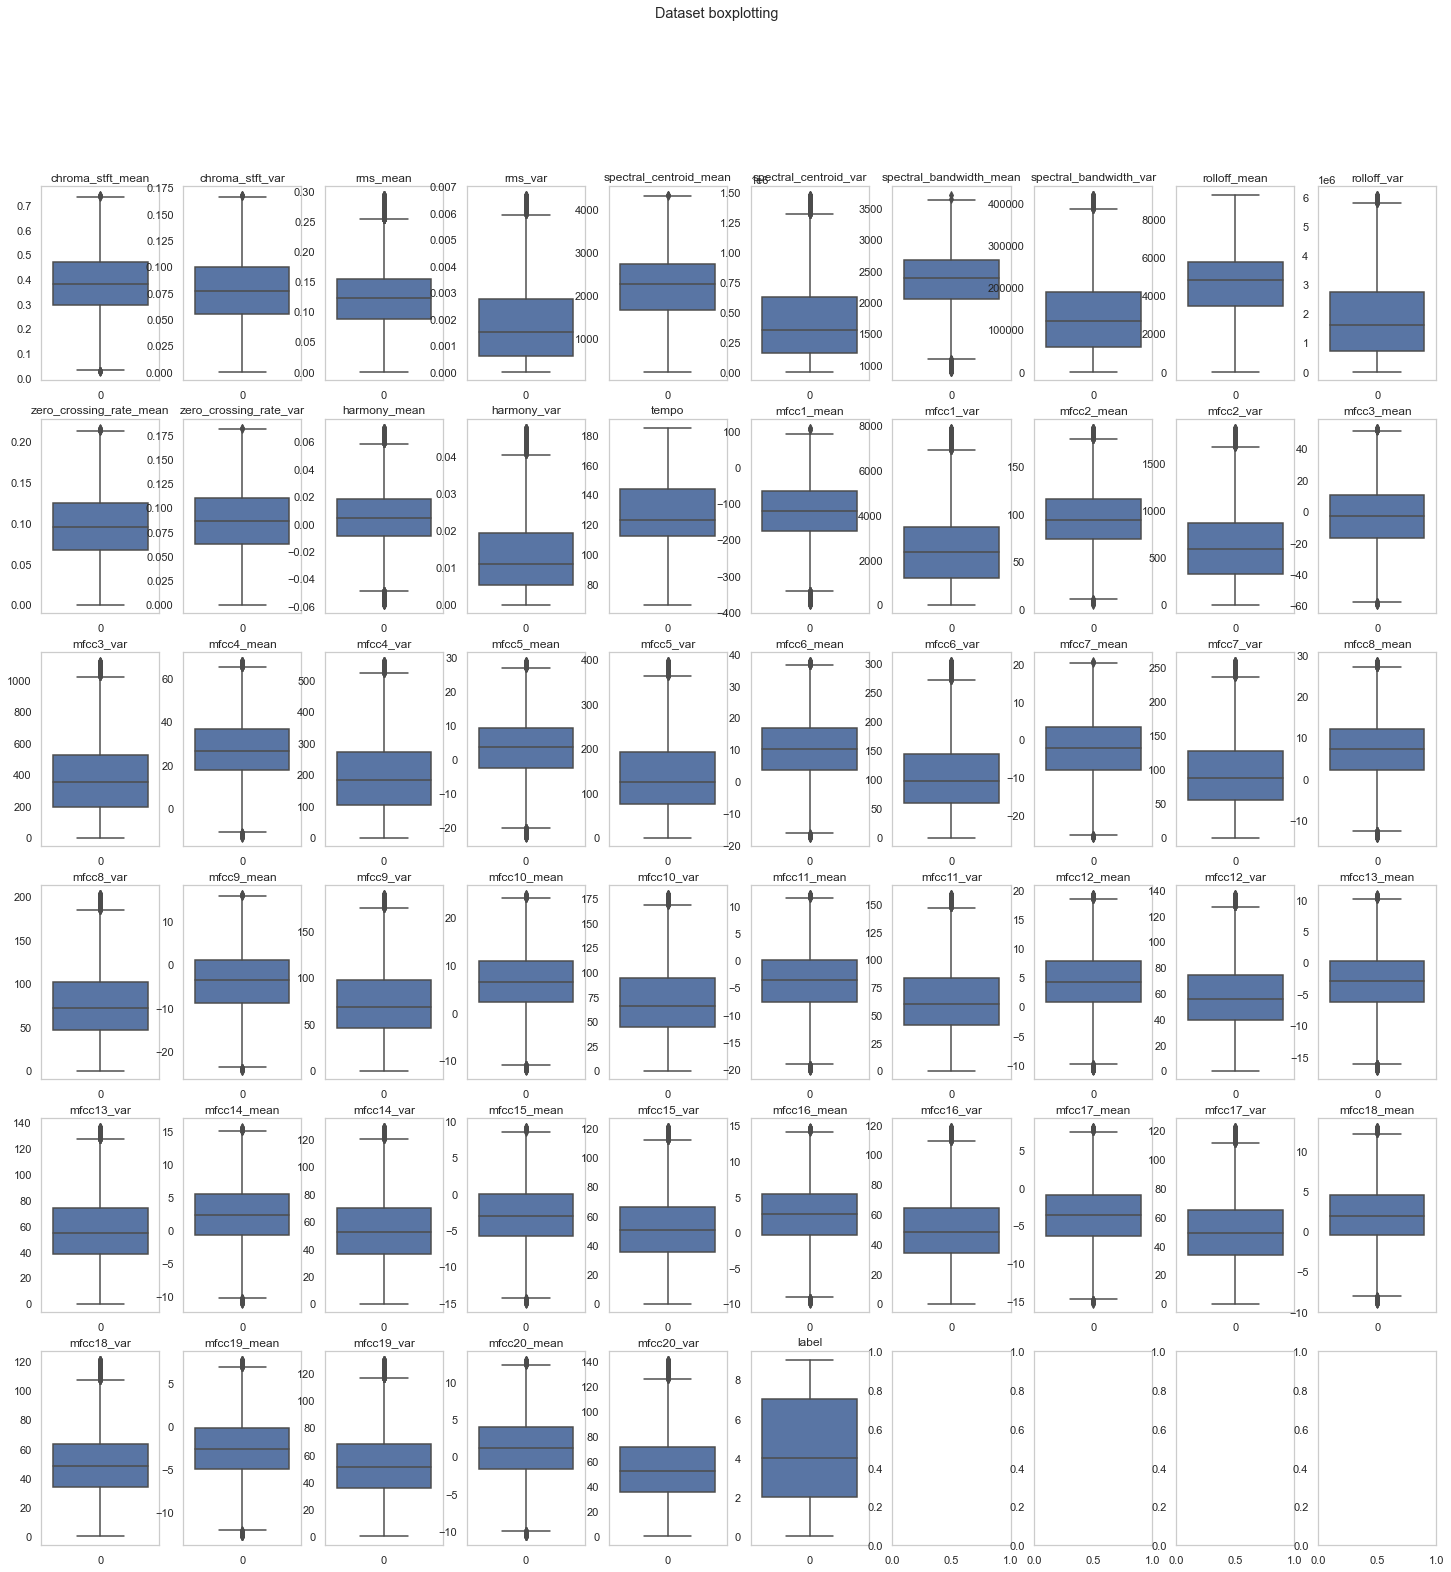

In [19]:
fig, axes = plt.subplots(6, 10, figsize=(25, 25))
fig.suptitle('Dataset boxplotting')

for r in range(6):
    for c in range(10):
        if r == 5 and c > 5: break
        col = training_set.columns[r*10+c]
        sns.boxplot(ax=axes[r, c], data=training_set[col])
        axes[r, c].set_title(col)

As we can see, most of the outliers were handled properly by changing their value to it's feature's median.

## 3.3 - Feature selection

In this section we'll analyse the correlation heatmap seen previously and select the features that perform better overall. This selection will be done by selecting the features based on a threshold and evaluate some models by using cross-validation with the KNN and Decision Tree algorithms.

<AxesSubplot:>

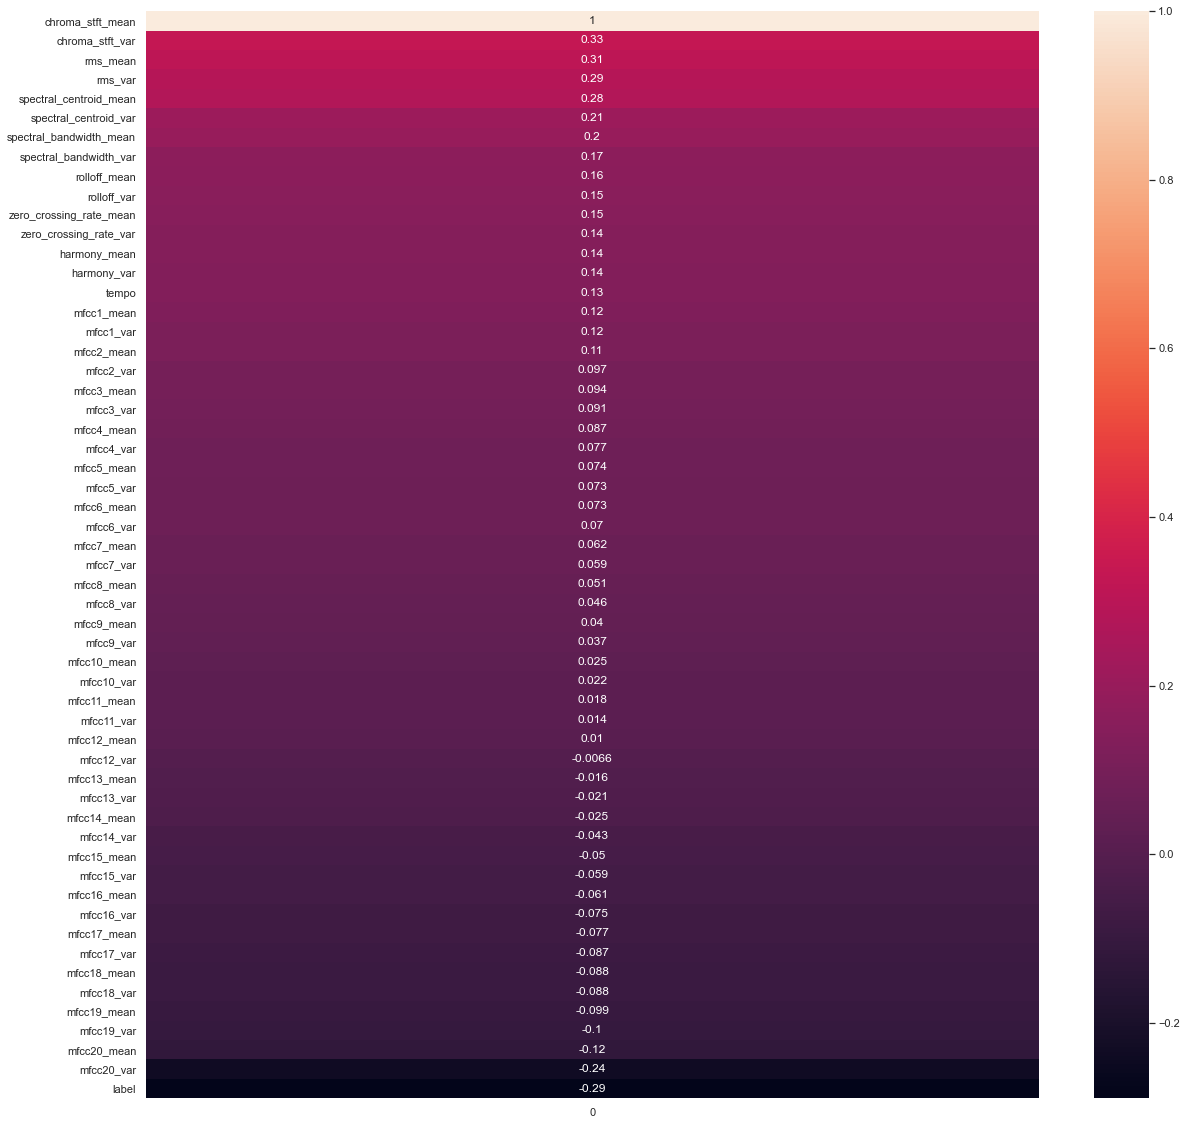

In [407]:
scaled_training_corr = scaled_training_set.corr()
corr = pd.DataFrame(data=scaled_training_corr.label)
corr = corr.sort_values(by=['label'], ascending=False)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr.label.values.reshape(56,1),  annot=True, ax=ax, yticklabels=scaled_training_set.columns)

In [409]:
max_thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
min_thresholds = [0, -0.05, -0.25]
knn_model = KNeighborsClassifier(n_neighbors=2)
results = []

for max_thresh in max_thresholds:
    for min_thresh in min_thresholds:
        print('.', end='')
        corr = scaled_training_set.corr().label
        selected_set = corr[(corr < min_thresh) | (corr >= max_thresh)]
        not_selected_cols = list(corr[(corr > min_thresh) & (corr < max_thresh)].index)
        selected_set = pd.DataFrame(data=scaled_training_set, columns=scaled_training_set.columns).drop(columns=not_selected_cols)
        selected_X = selected_set.drop(columns='label')
        selected_y = selected_set.label

        results.append({
            'min_thresh': min_thresh,
            'max_thresh': max_thresh,
            'knn': sum(cross_val_score(knn_model, selected_X, selected_y, cv=6)) / 6,
        })
        
results_df = pd.DataFrame(results)

..................

In [410]:
results_df = results_df.sort_values(['knn'], ascending=False).reset_index()
results_df

,index,min_thresh,max_thresh,knn
0,0,0.00,0.00,0.838299
1,1,-0.05,0.00,0.836624
2,2,-0.25,0.00,0.833564
3,3,0.00,0.05,0.828830
4,4,-0.05,0.05,0.826571
5,5,-0.25,0.05,0.823803
6,6,0.00,0.10,0.780902
7,7,-0.05,0.10,0.773763
8,8,-0.25,0.10,0.747614
9,9,0.00,0.15,0.717970


Given the previous results, we can conclude that the best relationship between model performance and number of features is obtained when removing the features with a correlation value between -0.25 and 0.0.<br/>
Now let's move on and experiment with the PCA and Isomap embedding algorithms.

In [20]:
min_thresh = 0
max_thresh = 0
corr = scaled_training_set.corr().label
selected_set = corr[(corr < min_thresh) | (corr >= max_thresh)]
not_selected_cols = list(corr[(corr > min_thresh) & (corr < max_thresh)].index)
selected_set = pd.DataFrame(data=scaled_training_set, columns=scaled_training_set.columns).drop(columns=not_selected_cols)
selected_testing_set = pd.DataFrame(data=scaled_testing_set, columns=scaled_testing_set.columns).drop(columns=not_selected_cols)
print(len(selected_set.columns))
selected_set.head()

56


,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
4063,-0.110116,-2.186272,2.485128,-0.716468,-1.277021,-1.060164,0.078667,-1.142681,-1.076586,-1.217454,...,-1.636765,1.083964,-1.617066,0.219087,-1.556465,2.031245,-1.532880,-0.166142,-1.469094,4
3367,-0.148269,-0.135560,0.401883,-0.041715,0.266900,-0.347263,-0.303851,-0.509304,-0.011432,-0.454453,...,-0.815567,-1.268875,-0.422179,-0.077665,-0.771244,0.228026,-0.639710,-0.526840,-0.775753,9
13175,-1.474195,-0.721265,-1.365016,-0.568965,-0.617925,-0.595687,-0.916433,-0.787858,-0.786228,-0.853722,...,-0.150691,0.091196,-0.276435,-0.416433,1.866914,-0.242040,0.902194,-1.391056,2.723534,1
461,-0.602451,0.189020,0.436289,0.875856,0.950942,2.355954,0.472736,0.862595,0.577161,1.544449,...,1.158860,0.902680,0.749941,0.827428,2.966731,1.819421,1.811700,0.077808,2.283784,7
12889,-0.973018,-1.133294,-1.345985,-0.644135,-1.039520,-0.964809,-1.162759,-0.894859,-1.183969,-1.087654,...,-0.706387,0.225275,-0.711984,-0.010067,-0.572587,-0.210684,-0.516793,-1.626137,-0.705461,1


## 3.4 - PCA

In [413]:
n_components = [10, 20, 30, 40]
res = []
selected_X = selected_set.drop(columns='label')
selected_y = selected_set.label

res.append({
    'n_components': -1,
    'knn': sum(cross_val_score(KNeighborsClassifier(), selected_X, selected_y, cv=4)) / 4,
})

for nc in n_components:
    knn_pipeline = make_pipeline(PCA(n_components=nc), KNeighborsClassifier())
    
    res.append({
        'n_components': nc,
        'knn': sum(cross_val_score(knn_pipeline, selected_X, selected_y, cv=6)) / 6,
    })
    
res_df = pd.DataFrame(res)
res_df

,n_components,knn
0,-1,0.815646
1,10,0.717387
2,20,0.790298
3,30,0.816375
4,40,0.822129


As shown in the table above, using PCA to reduce the number of features doesn't give better results. When used 40 components the results were very similar to when not using PCA (having 44 features), with the exception of the Decision Tree model, where the performance was best when not using the PCA algorithm.

# 3 - Initial baseline models evaluation

In [21]:
X_train = selected_set.drop(columns='label')
y_train = selected_set.label
X_test = selected_testing_set.drop(columns='label')
y_test = selected_testing_set.label

In [22]:
f1_scorer = make_scorer(f1_score, average='weighted')

## 3.1 - KNN

F1-score:  0.8341344199982283


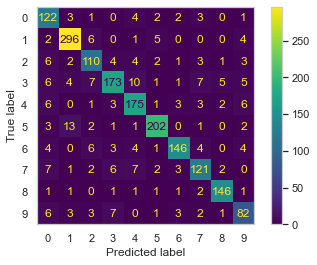

In [417]:
knn_model = KNeighborsClassifier()
knn_acc = sum(cross_val_score(knn_model, X_train, y_train, cv=9, scoring=f1_scorer, n_jobs=-1)) / 9
print("F1-score: ", knn_acc)
knn_model.fit(X_train, y_train)
cm = confusion_matrix(y_test, knn_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 3.2 - SVM 

F1-score: 0.8063541926978495


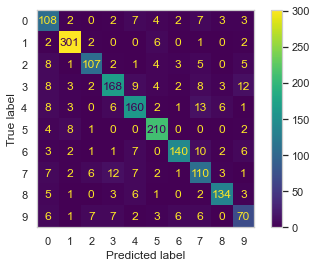

In [418]:
svm_model = SVC()
svm_acc = sum(cross_val_score(svm_model, X_train, y_train, cv=9, scoring=f1_scorer, n_jobs=-1)) / 9
print("F1-score: " + str(svm_acc))
svm_model.fit(X_train, y_train)
cm = confusion_matrix(y_test, svm_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot()

## 3.3 - Naive Bayes

F1-score: 0.4873671697564488


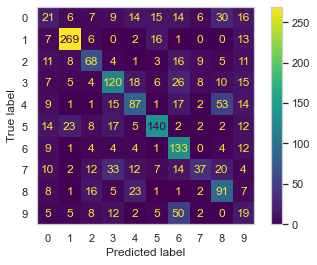

In [419]:
nb_model = GaussianNB()
nb_acc = sum(cross_val_score(nb_model, X_train, y_train, cv=9, scoring=f1_scorer, n_jobs=-1)) / 9
print("F1-score: " + str(nb_acc))
nb_model.fit(X_train, y_train)
cm = confusion_matrix(y_test, nb_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 3.4 - Decision Tree

F1-score: 0.6276528510011368


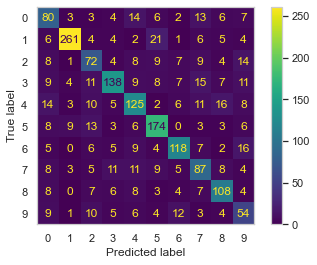

In [420]:
dt_model = DecisionTreeClassifier()
dt_acc = sum(cross_val_score(dt_model, X_train, y_train, cv=9, scoring=f1_scorer, n_jobs=-1)) / 9
print("F1-score: " + str(dt_acc))
dt_model.fit(X_train, y_train)
cm = confusion_matrix(y_test, dt_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 3.5 - Random Forest

F1-score: 0.813506155694971


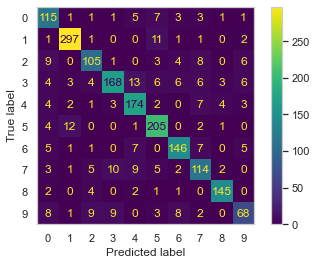

In [421]:
rf_model = RandomForestClassifier(n_estimators=300)
rf_acc = sum(cross_val_score(rf_model, X_train, y_train, cv=9, scoring=f1_scorer, n_jobs=-1)) / 9
print("F1-score: " + str(rf_acc))
rf_model.fit(X_train, y_train)
cm = confusion_matrix(y_test, rf_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 3.6 - Neural Network

In [51]:
_X_train, X_val, _y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [423]:
# Define model
nn_model = keras.Sequential([
    Dense(600, activation='relu', input_shape=[len(X_train.columns)]),
    Dropout(0.5),
    Dense(300, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
])
nn_model.compile(metrics=['accuracy'],
                    loss='sparse_categorical_crossentropy',
                    optimizer='adam')
nn_model.summary()

early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)
history = nn_model.fit(
    _X_train, _y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    callbacks=[early_stopping])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 600)               33600     
_________________________________________________________________
dropout_46 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 300)               180300    
_________________________________________________________________
dropout_47 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 128)               38528     
_________________________________________________________________
dropout_48 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 10)              

Epoch 49/1000
344/344 [==============================] - 1s 3ms/step - loss: 0.3997 - accuracy: 0.8658 - val_loss: 0.4491 - val_accuracy: 0.8572
Epoch 50/1000
344/344 [==============================] - 1s 3ms/step - loss: 0.4075 - accuracy: 0.8643 - val_loss: 0.4527 - val_accuracy: 0.8554
Epoch 51/1000
344/344 [==============================] - 1s 3ms/step - loss: 0.4129 - accuracy: 0.8599 - val_loss: 0.4585 - val_accuracy: 0.8540
Epoch 52/1000
344/344 [==============================] - 1s 3ms/step - loss: 0.3923 - accuracy: 0.8725 - val_loss: 0.4461 - val_accuracy: 0.8583
Epoch 53/1000
344/344 [==============================] - 1s 3ms/step - loss: 0.3978 - accuracy: 0.8656 - val_loss: 0.4499 - val_accuracy: 0.8551
Epoch 54/1000
344/344 [==============================] - 1s 2ms/step - loss: 0.3957 - accuracy: 0.8695 - val_loss: 0.4589 - val_accuracy: 0.8511
Epoch 55/1000
344/344 [==============================] - 1s 2ms/step - loss: 0.3892 - accuracy: 0.8678 - val_loss: 0.4612 - val_ac

F1-score: 0.8776695085810199


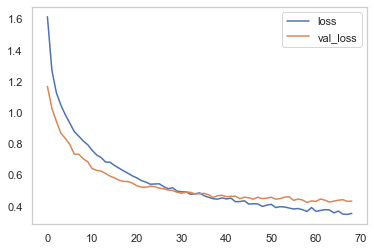

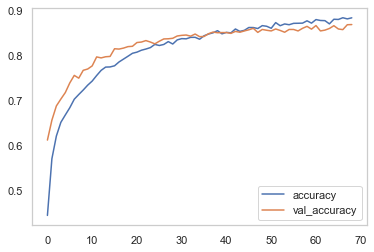

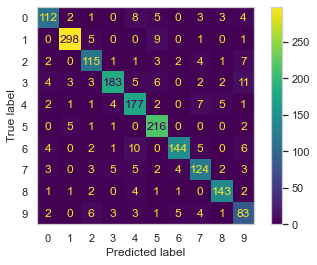

In [424]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
nn_prediction_distributions = nn_model.predict(X_test)
nn_prediction = []
for i in range(len(nn_prediction_distributions)):
    nn_prediction.append(np.argmax(nn_prediction_distributions[i]))
    
nn_acc = f1_score(y_test, nn_prediction, average='weighted')
print("F1-score: " + str(nn_acc))
cm = confusion_matrix(y_test, nn_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()

## 3.7 - Baseline model evaluation

<AxesSubplot:xlabel='model', ylabel='accuracy'>

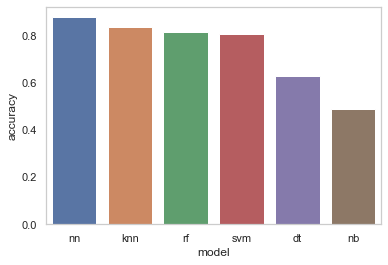

In [425]:
base_model_eval_data = { 'knn': knn_acc, 'svm': svm_acc, 'nb': nb_acc, 'dt': dt_acc,
                        'rf': rf_acc, 'nn': nn_acc }

list(base_model_eval_data.items())
base_model_eval_df = pd.DataFrame(data=list(base_model_eval_data.items()), columns=['model', 'accuracy'])
base_model_eval_df = base_model_eval_df.sort_values('accuracy', ascending=False).reset_index()
sns.barplot(x='model', y='accuracy', data=base_model_eval_df)

As shown in the graph above, the worst performant models were the Decision Tree and the Naive Bayes, which means that from now on, these will be ignored. The best model was a Neural Network with an aproximate accuracy of 92%.<br/>
On the next section, I'll be fine tuning the parameters of the best models: Neural Network, Convolutional Neural Network, KNN, Random Forest and SVM.

# 4 - Hyper-parameters fine tuning

## 4.1 - SVM tuning

In [40]:
svm_grid_search = {
    'kernel': ['linear', 'poly'],
    'gamma': [10],
    'C': [1, 5],
}
svm_params = []

for k in svm_grid_search['kernel']:
    for g in svm_grid_search['gamma']:
        for c in svm_grid_search['C']:
                print("Kernel: " + k + "  Gamma: " + str(g) + "  C: " + str(c) + "....  ", end = '')
                model = SVC(kernel=k, gamma=g, C=c)
                acc = sum(cross_val_score(model, X_train, y_train, cv=4, scoring=f1_scorer, n_jobs=-1)) / 4
                svm_params.append([k, g, c, acc])
                print(" Done (" + str(acc) + ")")
            
svm_params_df = pd.DataFrame(data=svm_params, columns=['kernel', 'gamma', 'C', 'f1_score'])
svm_params_df = svm_params_df.sort_values('f1_score', ascending=False)
svm_params_df.head()

Kernel: linear  Gamma: 10  C: 1....   Done (0.6669210044801006)
Kernel: linear  Gamma: 10  C: 5....   Done (0.6673414332571133)
Kernel: poly  Gamma: 10  C: 1....   Done (0.8217578397174438)
Kernel: poly  Gamma: 10  C: 5....   Done (0.8212086335347817)


,kernel,gamma,C,f1_score
2,poly,10,1,0.821758
3,poly,10,5,0.821209
1,linear,10,5,0.667341
0,linear,10,1,0.666921


F1-score: 0.8426842684268426


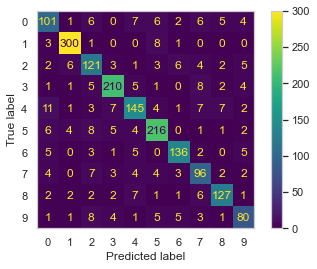

In [41]:
best_svm_params = svm_params_df.iloc[0]
best_svm_model = SVC(kernel=best_svm_params.kernel, C=best_svm_params.C, gamma=best_svm_params.gamma)
best_svm_model.fit(X_train, y_train)
best_svm_pred = best_svm_model.predict(X_test)
best_svm_acc = accuracy_score(y_test, best_svm_pred)
print("F1-score: " + str(best_svm_acc))

cm = confusion_matrix(y_test, best_svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 4.2 - Random Forest fine tuning

In [42]:
rf_grid_search = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [300, 400]
}
rf_params = []

for c in rf_grid_search['criterion']:
    for mf in rf_grid_search['max_features']:
        for ne in rf_grid_search['n_estimators']:
            print("Crit: " + c + "  MxFeat: " + str(mf) + "  nEst: " + str(ne)  + "....  ", end = '')
            model = RandomForestClassifier(
                criterion=c, max_features=mf, n_estimators=ne,
            )
            acc = sum(cross_val_score(model, X_train, y_train, cv=4, scoring=f1_scorer, n_jobs=-1)) / 4
            rf_params.append([c, mf, ne, acc])
            print(" Done (" + str(acc) + ")")
                     
rf_params_cols = list(rf_grid_search.keys()) + ['f1_score']
rf_params_df = pd.DataFrame(data=rf_params, columns=rf_params_cols)
rf_params_df = rf_params_df.sort_values('f1_score', ascending=False)
rf_params_df.head()

Crit: gini  MxFeat: sqrt  nEst: 300....   Done (0.8067646279269058)
Crit: gini  MxFeat: sqrt  nEst: 400....   Done (0.8065260950862473)
Crit: gini  MxFeat: log2  nEst: 300....   Done (0.8005998787704078)
Crit: gini  MxFeat: log2  nEst: 400....   Done (0.80322416523891)
Crit: entropy  MxFeat: sqrt  nEst: 300....   Done (0.8052049056310298)
Crit: entropy  MxFeat: sqrt  nEst: 400....   Done (0.8055004051223921)
Crit: entropy  MxFeat: log2  nEst: 300....   Done (0.8018480183882448)
Crit: entropy  MxFeat: log2  nEst: 400....   Done (0.8030578561841362)


,criterion,max_features,n_estimators,f1_score
0,gini,sqrt,300,0.806765
1,gini,sqrt,400,0.806526
5,entropy,sqrt,400,0.805500
4,entropy,sqrt,300,0.805205
3,gini,log2,400,0.803224


As seen in the results above, there is still room for improvement relating to the n_estimators parameter. So, I'll run some more tests to see if there are better values for this parameter.

In [43]:
rf_grid_search2 = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt'],
    'n_estimators': [700, 800]
}

for c in rf_grid_search2['criterion']:
    for mf in rf_grid_search2['max_features']:
        for ne in rf_grid_search2['n_estimators']:
            print("Crit: " + c + "  MxFeat: " + str(mf) + "  nEst: " + str(ne)  + "....  ", end = '')
            model = RandomForestClassifier(
                criterion=c, max_features=mf, n_estimators=ne,
            )
            acc = sum(cross_val_score(model, X_train, y_train, cv=4, scoring=f1_scorer, n_jobs=-1)) / 4
            rf_params.append([c, mf, ne, acc])
            print(" Done (" + str(acc) + ")")
                     
rf_params_cols = list(rf_grid_search.keys()) + ['f1_score']
rf_params_df = pd.DataFrame(data=rf_params, columns=rf_params_cols)
rf_params_df = rf_params_df.sort_values('f1_score', ascending=False)
rf_params_df.head()

Crit: gini  MxFeat: sqrt  nEst: 700....   Done (0.8073300736924387)
Crit: gini  MxFeat: sqrt  nEst: 800....   Done (0.8095256631964481)
Crit: entropy  MxFeat: sqrt  nEst: 700....   Done (0.8085246144997258)
Crit: entropy  MxFeat: sqrt  nEst: 800....   Done (0.8085664115696649)


,criterion,max_features,n_estimators,f1_score
9,gini,sqrt,800,0.809526
11,entropy,sqrt,800,0.808566
10,entropy,sqrt,700,0.808525
8,gini,sqrt,700,0.807330
0,gini,sqrt,300,0.806765


F1-score: 0.8509350935093509


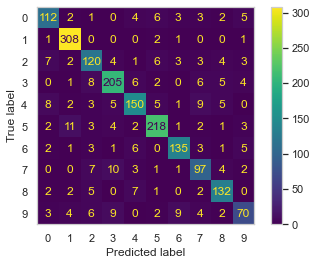

In [44]:
best_rf_params = rf_params_df.iloc[1]
best_rf_model = RandomForestClassifier(
                criterion=best_rf_params.criterion,
                max_features=best_rf_params.max_features,
                n_estimators=best_rf_params.n_estimators
            )
best_rf_model.fit(X_train, y_train)
best_rf_pred = best_rf_model.predict(X_test)
best_rf_acc = accuracy_score(y_test, best_rf_pred)
print("F1-score: " + str(best_rf_acc))

cm = confusion_matrix(y_test, best_rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 4.3 - KNN fine tuning

In [45]:
knn_grid_search = {
    'n_neighbors': [2, 3, 5],
    'weights': ['distance', 'uniform'],
    'p': [1, 2],
}
knn_params = []

for nn in knn_grid_search['n_neighbors']:
    for w in knn_grid_search['weights']:
        for p in knn_grid_search['p']:
            print("NN: " + str(nn) + "  W: " + w + "  P: " + str(p) + "....  ", end = '')
            model = KNeighborsClassifier(n_neighbors=nn, weights=w, p=p)
            acc = sum(cross_val_score(model, X_train, y_train, cv=4, scoring=f1_scorer, n_jobs=-1)) / 4
            knn_params.append([nn, w, p, acc])
            print(" Done (" + str(acc) + ")")
            
knn_params_df = pd.DataFrame(data=knn_params, columns=['n_neighbors', 'weights', 'p', 'f1_score'])
knn_params_df = knn_params_df.sort_values('f1_score', ascending=False)
knn_params_df.head()

NN: 2  W: distance  P: 1....   Done (0.8741650435472959)
NN: 2  W: distance  P: 2....   Done (0.8600125676473346)
NN: 2  W: uniform  P: 1....   Done (0.8459720598702372)
NN: 2  W: uniform  P: 2....   Done (0.8297285824830202)
NN: 3  W: distance  P: 1....   Done (0.8603251513680581)
NN: 3  W: distance  P: 2....   Done (0.8496161708054722)
NN: 3  W: uniform  P: 1....   Done (0.8455734696307909)
NN: 3  W: uniform  P: 2....   Done (0.8343463148060324)
NN: 5  W: distance  P: 1....   Done (0.84962709964461)
NN: 5  W: distance  P: 2....   Done (0.8342325129347046)
NN: 5  W: uniform  P: 1....   Done (0.8328696300585474)
NN: 5  W: uniform  P: 2....   Done (0.8171511779793044)


,n_neighbors,weights,p,f1_score
0,2,distance,1,0.874165
4,3,distance,1,0.860325
1,2,distance,2,0.860013
8,5,distance,1,0.849627
5,3,distance,2,0.849616


F1-score: 0.8976897689768977


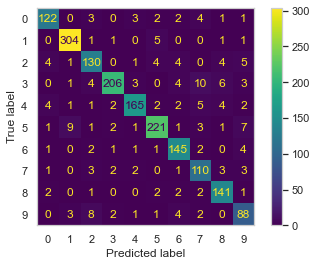

In [46]:
best_knn_params = knn_params_df.iloc[0]
best_knn_model = KNeighborsClassifier(n_neighbors=best_knn_params.n_neighbors,
                                      weights=best_knn_params.weights,
                                      p=best_knn_params.p)
best_knn_model.fit(X_train, y_train)
best_knn_pred = best_knn_model.predict(X_test)
best_knn_acc = accuracy_score(y_test, best_knn_pred)
print("F1-score: " + str(best_knn_acc))

cm = confusion_matrix(y_test, best_knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 4.4 - Neural Network fine tuning

In [52]:
# Define model
nn_model = keras.Sequential([
    Dense(200, activation='relu', input_shape=[len(X_train.columns)]),
    Dropout(0.5),
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.7),
    Dense(10, activation='softmax')
])
nn_model.compile(metrics=['accuracy'],
                    loss='sparse_categorical_crossentropy',
                    optimizer='adam')
nn_model.summary()

early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)
history = nn_model.fit(
    _X_train, _y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    callbacks=[early_stopping])

nn_prediction_distributions = nn_model.predict(X_test)
nn_prediction = []
for i in range(len(nn_prediction_distributions)):
    nn_prediction.append(np.argmax(nn_prediction_distributions[i]))
    
nn_acc = f1_score(y_test, nn_prediction, average='weighted')
print("F1-score: " + str(nn_acc))
#nn_best_params.append(['ftrl', nn_acc])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 200)               11200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               25728     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

Epoch 49/1000
344/344 [==============================] - 1s 1ms/step - loss: 0.7419 - accuracy: 0.7709 - val_loss: 0.6124 - val_accuracy: 0.8056
Epoch 50/1000
344/344 [==============================] - 1s 2ms/step - loss: 0.7191 - accuracy: 0.7736 - val_loss: 0.6253 - val_accuracy: 0.8023
Epoch 51/1000
344/344 [==============================] - 1s 1ms/step - loss: 0.7027 - accuracy: 0.7779 - val_loss: 0.6093 - val_accuracy: 0.8020
Epoch 52/1000
344/344 [==============================] - 1s 2ms/step - loss: 0.6954 - accuracy: 0.7791 - val_loss: 0.6209 - val_accuracy: 0.7961
Epoch 53/1000
344/344 [==============================] - 1s 2ms/step - loss: 0.7185 - accuracy: 0.7739 - val_loss: 0.6106 - val_accuracy: 0.8041
Epoch 54/1000
344/344 [==============================] - 1s 2ms/step - loss: 0.7072 - accuracy: 0.7778 - val_loss: 0.6036 - val_accuracy: 0.8041
Epoch 55/1000
344/344 [==============================] - 1s 2ms/step - loss: 0.7155 - accuracy: 0.7762 - val_loss: 0.6056 - val_ac

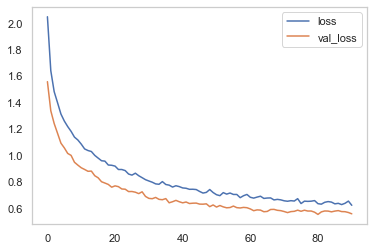

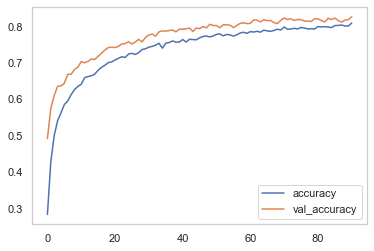

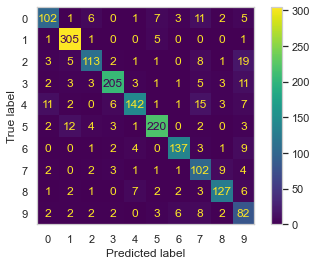

In [54]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
nn_prediction_distributions = nn_model.predict(X_test)
nn_prediction = []
for i in range(len(nn_prediction_distributions)):
    nn_prediction.append(np.argmax(nn_prediction_distributions[i]))
    
cm = confusion_matrix(y_test, nn_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

As shown in the table above, the best optimizer seems to be the 'rmsprop'.

## 4.6 - Model's fine tuning evaluation

  model  f1_score
0   knn  0.897690
1    rf  0.850935
2    nn  0.846601
3   svm  0.842684


<AxesSubplot:xlabel='model', ylabel='f1_score'>

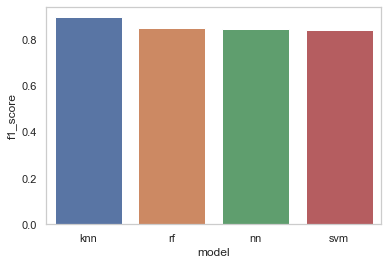

In [55]:
ft_model_eval_data = { 'knn': best_knn_acc, 'svm': best_svm_acc,
                        'rf': best_rf_acc, 'nn': nn_acc }

ft_model_eval_df = pd.DataFrame(data=list(ft_model_eval_data.items()), columns=['model', 'f1_score'])
ft_model_eval_df = ft_model_eval_df.sort_values('f1_score', ascending=False).reset_index()
print(ft_model_eval_df[['model', 'f1_score']])
sns.barplot(x='model', y='f1_score', data=ft_model_eval_df)

After tuning the different models carefully, we can conclude that the best models were the KNN and the Neural Network. Even though the CNN had 90% accuracy for the test set, it tends to overfit a lot, which is a problem. The SVM also appeared promising, but it didn't perform as well as the KNN and the NN. Finally, the Random Forest ensemble turned to be the worst model. We can hypothesise that this problem can't be efficiently solved by resorting tree based models like Decision Trees and Random Forests.

# 5 - Ensembles

## 5.1 - Bagging

F1_score: 0.8754603656441334


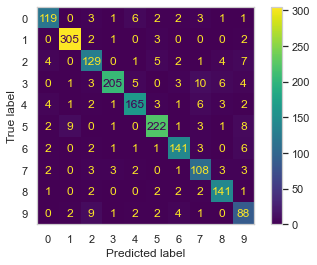

In [27]:
bagging_model = BaggingClassifier(
    base_estimator=KNeighborsClassifier(n_neighbors=2, weights='distance', p=1),
    n_estimators=10, random_state=0)

bagging_acc = sum(cross_val_score(bagging_model, X_train, y_train, scoring=f1_scorer, n_jobs=-1, cv=9)) / 9
print("F1_score: " + str(bagging_acc))

bagging_model.fit(X_train, y_train)
bagging_preds = bagging_model.predict(X_test)
cm = confusion_matrix(y_test, bagging_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 5.2 - AdaBoost

F1-score: 0.6140789279585496


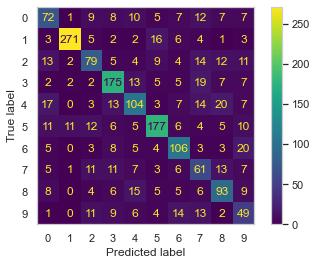

In [28]:
adaboost_model = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=300)

adaboost_acc = sum(cross_val_score(adaboost_model, X_train, y_train, scoring=f1_scorer, cv=9)) / 9
print("F1-score: " + str(adaboost_acc))

adaboost_model.fit(X_train, y_train)
adaboost_preds = adaboost_model.predict(X_test)
cm = confusion_matrix(y_test, adaboost_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 5.3 - GradientBoosting

F1-score: 0.7444765492302152


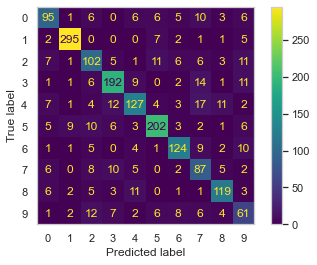

In [23]:
gradient_boost_model = GradientBoostingClassifier()

gradient_boost_acc = sum(cross_val_score(gradient_boost_model, X_train, y_train, scoring=f1_scorer, cv=9)) / 9
print("F1-score: " + str(gradient_boost_acc))

gradient_boost_model.fit(X_train, y_train)
gradient_boost_preds = gradient_boost_model.predict(X_test)
cm = confusion_matrix(y_test, gradient_boost_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 5.4 - Voting

F1-score: 0.8860663316046733


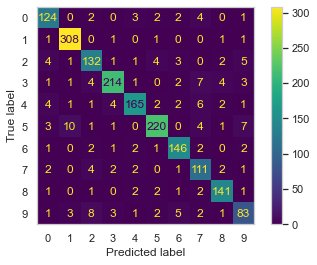

In [24]:
voting_model = VotingClassifier(estimators=[
        ('knn1', KNeighborsClassifier(n_neighbors=2, weights='distance', p=1)),
        #('svm', SVC(kernel='poly', gamma=100, C=10)),
        ('knn2', KNeighborsClassifier(n_neighbors=3, weights='distance', p=1)),
        ('knn3', KNeighborsClassifier(n_neighbors=2, weights='distance', p=2)),
        ('rf', RandomForestClassifier(criterion='entropy', n_estimators=150, max_features='sqrt')),
    ],
    voting='hard',
    n_jobs=-1
)

voting_acc = sum(cross_val_score(voting_model, X_train, y_train, scoring=f1_scorer, n_jobs=-1, cv=9)) / 9
print("F1-score: " + str(voting_acc))

voting_model.fit(X_train, y_train)
voting_preds = voting_model.predict(X_test)
cm = confusion_matrix(y_test, voting_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 5.5 - Stacking

F1-score: 0.8877747907345022


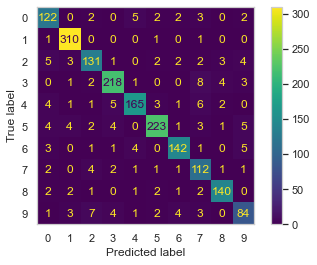

In [25]:
stacking_model = StackingClassifier(estimators=[
        ('knn1', KNeighborsClassifier(n_neighbors=2, weights='distance', p=1)),
        ('svm', SVC(kernel='poly', gamma=10, C=1)),
        ('knn2', KNeighborsClassifier(n_neighbors=3, weights='distance', p=1)),
        ('knn3', KNeighborsClassifier(n_neighbors=2, weights='distance', p=2)),
        ('rf', RandomForestClassifier(criterion='entropy', n_estimators=150, max_features='sqrt')),
        #('mlp', MLPClassifier([400, 300, 128, 40], activation='relu', shuffle=True,
        #                      early_stopping=True, validation_fraction=0.15, )),
    ],
    final_estimator=LogisticRegression(max_iter=10000),
    n_jobs=-1
)

stacking_acc = sum(cross_val_score(stacking_model, X_train, y_train, scoring=f1_scorer, cv=9)) / 9
print("F1-score: " + str(stacking_acc))

stacking_model.fit(X_train, y_train)
stacking_preds = stacking_model.predict(X_test)
cm = confusion_matrix(y_test, stacking_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 5.6 - Ensemble's results

              model  f1_score
0          Stacking  0.887775
1            Voting  0.886066
2           Bagging  0.875460
3  GradientBoosting  0.744477
4          AdaBoost  0.614079


<AxesSubplot:xlabel='model', ylabel='f1_score'>

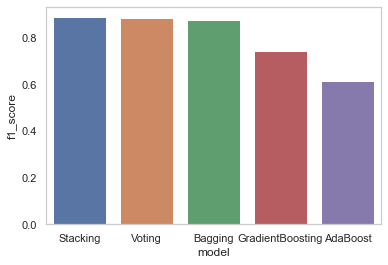

In [29]:
ensembles_eval_data = { 'Bagging': bagging_acc, 'GradientBoosting': gradient_boost_acc,
                        'AdaBoost': adaboost_acc, 'Voting': voting_acc, 'Stacking': stacking_acc }

ensemble_eval_df = pd.DataFrame(data=list(ensembles_eval_data.items()), columns=['model', 'f1_score'])
ensemble_eval_df = ensemble_eval_df.sort_values('f1_score', ascending=False).reset_index()
print(ensemble_eval_df[['model', 'f1_score']])
sns.barplot(x='model', y='f1_score', data=ensemble_eval_df)

# 6 - Final results

              model  f1_score
0               knn  0.897690
0          Stacking  0.887775
1            Voting  0.886066
2           Bagging  0.875460
1                rf  0.850935
2                nn  0.846601
3               svm  0.842684
3  GradientBoosting  0.744477
4          AdaBoost  0.614079


<AxesSubplot:xlabel='model', ylabel='f1_score'>

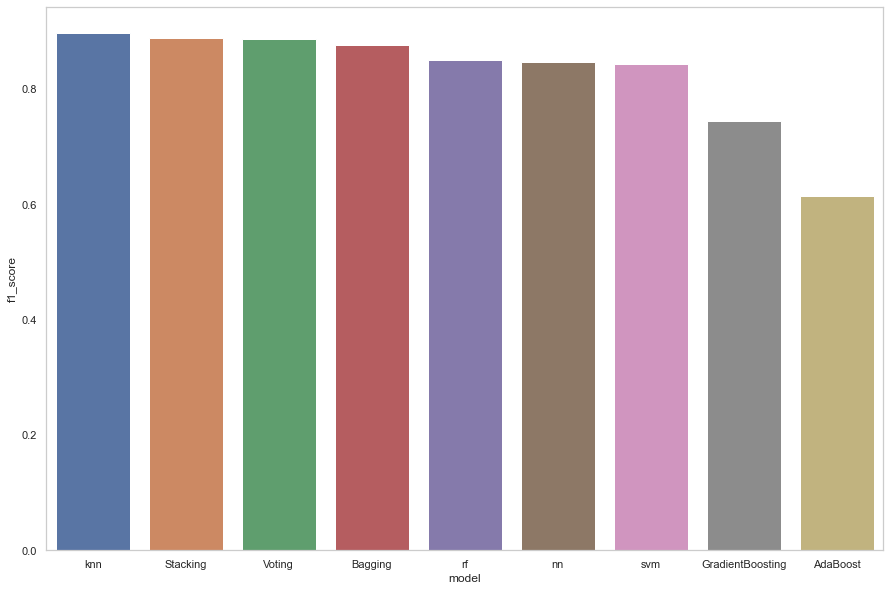

In [56]:
final_results_df = pd.concat([ft_model_eval_df, ensemble_eval_df])
final_results_df = final_results_df.sort_values('f1_score', ascending=False)
print(final_results_df[['model', 'f1_score']])

fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x='model', y='f1_score', data=final_results_df, ax=ax)